In [20]:
from PyLayouts import Swizzled_layout, Draw
import numpy as np

In [21]:
%load_ext nvcc4jupyter

from nvcc4jupyter import set_defaults
set_defaults(compiler_args='-arch=sm_100a -Xptxas=-v -O0 -I/workspace/cutlass/include')

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


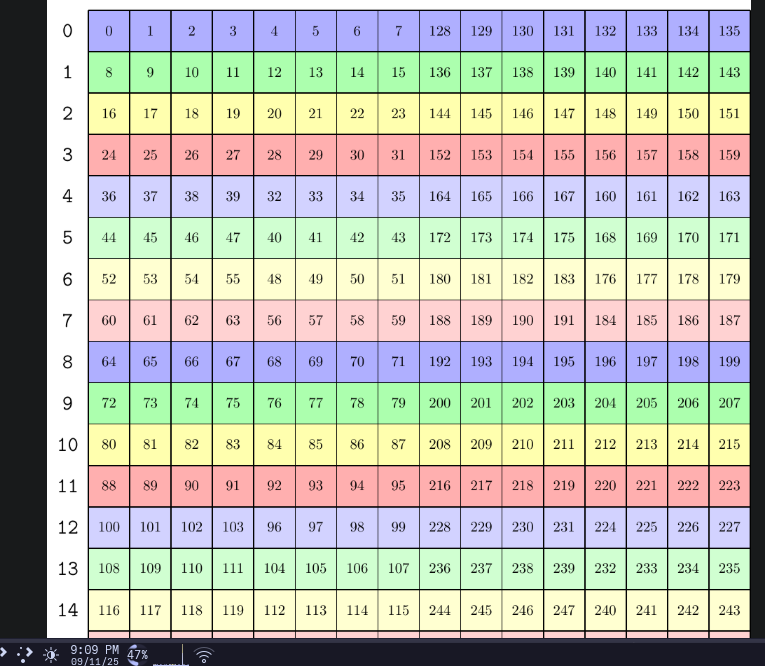

"K MAJOR 32 byte swizzle TF32 they say" 

Exact layout : Swizzle<1,4,3> o ((8,2),(4,4)):((8,64),(1,4))

Canonical Layout :Swizzle<1,4,3> o ((8,m),(T,2k)):((2T,SBO),(1,T))


In [ ]:
%%cuda 
#include<stdio.h> 
#include <cute/tensor.hpp>




using namespace cute;


int main() {
    
    // 1. --- SET YOUR PARAMS HERE ---
    
    // Swizzle<BBits, MBase, SShift>
    using MySwizzle = Swizzle<1, 4, 3>;

    // Shape: (8, 2, 4, 4)
    auto shape = make_shape(Int<8>{}, Int<2>{}, Int<4>{}, Int<4>{});

    // Stride: (8, 64, 1, 4)
    auto stride = make_stride(Int<8>{}, Int<64>{}, Int<1>{}, Int<4>{});
    
    // ---------------------------------
    
    
    // --- CUTE Logic (runs on CPU) ---
    
    // Calculate total number of elements
    const int N_ELEMS = size(shape);

    // Create the layout, swizzle function, and composed layout
    auto layout = make_layout(shape, stride);
    MySwizzle swizzle_fn;
    auto swizzled_layout = composition(swizzle_fn, layout);
    
    
    // --- Print the results ---

    // Print the regular layout on one line
    for (int i = 0; i < N_ELEMS; i++) {
        printf("%d", layout(i));
        if (i < N_ELEMS - 1) {
            printf(",");
        }
    }
    printf("\n"); // Newline for the next layout
    
    // Print the swizzled layout on a second line
    for (int i = 0; i < N_ELEMS; i++) {
        printf("%d", swizzled_layout(i));
        if (i < N_ELEMS - 1) {
            printf(",");
        }
    }
    printf("\n"); // Final newline
            
    return 0;
}

0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,1,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,2,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,3,11,19,27,35,43,51,59,67,75,83,91,99,107,115,123,4,12,20,28,36,44,52,60,68,76,84,92,100,108,116,124,5,13,21,29,37,45,53,61,69,77,85,93,101,109,117,125,6,14,22,30,38,46,54,62,70,78,86,94,102,110,118,126,7,15,23,31,39,47,55,63,71,79,87,95,103,111,119,127,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,129,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,130,11,19,27,35,43,51,59,67,75,83,91,99,107,115,123,131,12,20,28,36,44,52,60,68,76,84,92,100,108,116,124,132,13,21,29,37,45,53,61,69,77,85,93,101,109,117,125,133,14,22,30,38,46,54,62,70,78,86,94,102,110,118,126,134,15,23,31,39,47,55,63,71,79,87,95,103,111,119,127,135
0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,1,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,2,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,3,11,19,27,35,43,51,59,67,75,83,

In [23]:
#Swizzle<1,4,3> o ((8,2),(4,4)):((8,64),(1,4))
b_bits = 1
m_base = 4
s_shift = 3
shape = (8,2,4,4)
stride = (8,64,1,4)
L = Swizzled_layout(shape, stride, m_base, b_bits, s_shift)

In [24]:
L_verif = np.array([0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,1,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,2,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,3,11,19,27,35,43,51,59,67,75,83,91,99,107,115,123,4,12,20,28,36,44,52,60,68,76,84,92,100,108,116,124,5,13,21,29,37,45,53,61,69,77,85,93,101,109,117,125,6,14,22,30,38,46,54,62,70,78,86,94,102,110,118,126,7,15,23,31,39,47,55,63,71,79,87,95,103,111,119,127,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,129,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,130,11,19,27,35,43,51,59,67,75,83,91,99,107,115,123,131,12,20,28,36,44,52,60,68,76,84,92,100,108,116,124,132,13,21,29,37,45,53,61,69,77,85,93,101,109,117,125,133,14,22,30,38,46,54,62,70,78,86,94,102,110,118,126,134,15,23,31,39,47,55,63,71,79,87,95,103,111,119,127,135])
L_swiz_verif = np.array([0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,1,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,2,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,3,11,19,27,35,43,51,59,67,75,83,91,99,107,115,123,4,12,20,28,36,44,52,60,68,76,84,92,100,108,116,124,5,13,21,29,37,45,53,61,69,77,85,93,101,109,117,125,6,14,22,30,38,46,54,62,70,78,86,94,102,110,118,126,7,15,23,31,39,47,55,63,71,79,87,95,103,111,119,127,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,144,9,17,25,33,41,49,57,65,73,81,89,97,105,113,121,145,10,18,26,34,42,50,58,66,74,82,90,98,106,114,122,146,11,19,27,35,43,51,59,67,75,83,91,99,107,115,123,147,12,20,28,36,44,52,60,68,76,84,92,100,108,116,124,148,13,21,29,37,45,53,61,69,77,85,93,101,109,117,125,149,14,22,30,38,46,54,62,70,78,86,94,102,110,118,126,150,15,23,31,39,47,55,63,71,79,87,95,103,111,119,127,151
])

In [27]:
L_verif.shape
L_swiz_verif.shape

(256,)

In [29]:
print(np.allclose(L.realized_layout, L_verif))
print(np.allclose(L.final_layout, L_swiz_verif))

True
True


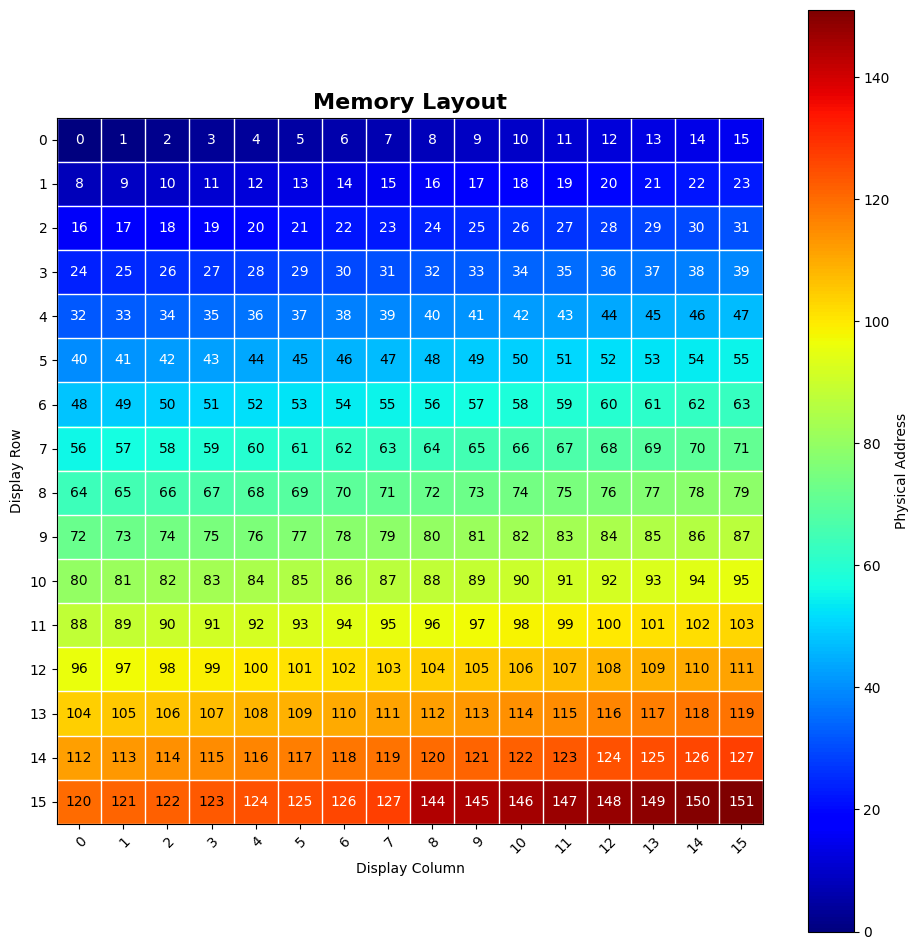

In [34]:
d = Draw(L.final_layout, display_dim = 16, order = "col")
d.show()